# Using AirBnB data to understand the homeowners' market in Seattle

I approached the data as if I were a homeowner Seattle. If I were a homeowner in Seattle, my main objective would be to offer a great experience for my guests while maximizing revenues. Hence, I structured my business understanding questions around these objectives. My questions for my analysis are thus as follows: 

### 1. Business Understanding:

##### 1. [Can we predict what drives higher ratings](#pred-higher-ratings)?

If I were a Seattle home owner, I would find out if data could inform what would lead to higher ratings. In using data to answer this question, I would be able to determine if I could craft an experience that will ensure I get high ratings. In particular, it would be useful to know what are the levers that drive higher ratings.

##### 2. [When and where are the most popular times of the year for rentals of Seattle homes](#popular)?

As an aspiring home owner, I would like to know if there were particular areas that are popular among guests, as well as the most popular times of the year so that I could consider renting out homes in popular areas while being prepared for those times. If I know when the most popular times of the year are, I would know to be prepared when there is peak travelling seasons. Knowing where the most popular areas are is also valuable for determining my strategy if I am looking to purchase a home to rent out on AirBnB.

##### 3. [When and where are the highest revenue-generating times of the year for Seattle home-owners](#revenue)?

In order to set prices competitively, it would be useful to know when are the highest prices for rentals, as well as where are the highest priced areas. Knowing the areas that are highest revenue-generating would also enable me to strategise depending on where I am living, what would be the most competitive prices. 

### 2. Data Understanding

### 2.1 Gather data

All data was obtained from Kaggle: https://www.kaggle.com/airbnb/seattle/home

In [420]:
#import libraries and load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import collections
from itertools import chain
import sklearn
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

listings = pd.read_csv('./seattle/listings.csv')
calendar = pd.read_csv('./seattle/calendar.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

### 2.2 Assess & preliminary cleaning of data

In [421]:
#explore columns in datasets
print(listings.columns.values)
print(calendar.columns.values)
print(reviews.columns.values)

['id' 'listing_url' 'scrape_id' 'last_scraped' 'name' 'summary' 'space'
 'description' 'experiences_offered' 'neighborhood_overview' 'notes'
 'transit' 'thumbnail_url' 'medium_url' 'picture_url' 'xl_picture_url'
 'host_id' 'host_url' 'host_name' 'host_since' 'host_location'
 'host_about' 'host_response_time' 'host_response_rate'
 'host_acceptance_rate' 'host_is_superhost' 'host_thumbnail_url'
 'host_picture_url' 'host_neighbourhood' 'host_listings_count'
 'host_total_listings_count' 'host_verifications' 'host_has_profile_pic'
 'host_identity_verified' 'street' 'neighbourhood'
 'neighbourhood_cleansed' 'neighbourhood_group_cleansed' 'city' 'state'
 'zipcode' 'market' 'smart_location' 'country_code' 'country' 'latitude'
 'longitude' 'is_location_exact' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'bed_type' 'amenities'
 'square_feet' 'price' 'weekly_price' 'monthly_price' 'security_deposit'
 'cleaning_fee' 'guests_included' 'extra_people' 'minimum_nights'
 'm

It appears that all the datasets can potentially be merged by their listing ID, if needed during analysis. First, check that all columns are variables and rows are individuals.

In [422]:
#check no. of rows and columns
print(listings.shape)
print(calendar.shape)
print(reviews.shape)

(3818, 92)
(1393570, 4)
(84849, 6)


In [423]:
#check for missing values in the columns for each dataset, get percentages
(listings.isnull().sum()/len(listings)).sort_values(ascending=False)

license                             1.000000
square_feet                         0.974594
monthly_price                       0.602672
security_deposit                    0.511262
weekly_price                        0.473808
notes                               0.420639
neighborhood_overview               0.270299
cleaning_fee                        0.269775
transit                             0.244631
host_about                          0.224987
host_acceptance_rate                0.202462
review_scores_accuracy              0.172342
review_scores_checkin               0.172342
review_scores_value                 0.171818
review_scores_location              0.171556
review_scores_cleanliness           0.171032
review_scores_communication         0.170508
review_scores_rating                0.169460
reviews_per_month                   0.164222
first_review                        0.164222
last_review                         0.164222
space                               0.149031
host_respo

In [424]:
#check distribution of null values
(listings.isnull().sum()/len(listings)).describe()

count    92.000000
mean      0.084893
std       0.181492
min       0.000000
25%       0.000000
50%       0.000000
75%       0.136983
max       1.000000
dtype: float64

For the listing dataset, it looks as though there are a number of columns containing missing values. The license column is completely null.

Looking at the spread of null values, we can see that the average % of null rows in each column is around 10-11%, with 75% of columns having 17% of rows being missing. As I would prefer not to drop columns unnecessarily, I would consider drop columns with more than 30% rows that are null.

In [425]:
(calendar.isnull().sum()/len(calendar)).sort_values(ascending=False)

price         0.32939
available     0.00000
date          0.00000
listing_id    0.00000
dtype: float64

For the calendar dataset, the price column has 32% of rows containing null values.

In [426]:
(reviews.isnull().sum()/len(reviews)).sort_values(ascending=False)

comments         0.000212
reviewer_name    0.000000
reviewer_id      0.000000
date             0.000000
id               0.000000
listing_id       0.000000
dtype: float64

The reviews dataset has almost no missing values.

In order to prepare the data for the 3 business questions, we need to look at the 3 datasets and determine which datasets and columns contained within them that are relevant to the question above.

We have 3 datasets: listings, calendar and reviews. Based on our brief exploration above, we can see that the dataset most relevant to our analysis for this question is the listings dataset. The calendar dataset looks to be more relevant to supplement the listings dataset for our 2nd question on popular times and availability. 

Meanwhile, the reviews dataset is more relevant for qualitative predictors and is mainly unstructured data, hence we will only analyse it if we lack sufficient information to answer our questions.

After determining the datasets that are relevant for answering our questions, we move to preparing the data for our analysis.

### 2.2: Business Question 1: Can we predict what drives higher ratings? <a id='pred-higher-ratings'></a>
#### 2.2.1 Data Preparation & cleaning

#### 2.2.1.a Treatment of missing values

Seeing as there are many missing values in the license column, and it is not relevant to the questions above, we can drop it from our analysis dataset. As mentioned above, I would also drop columns that are more than 30% of missing rows, if there are not too many and we don't foresee losing too much information.

In [427]:
#drop license column
listings.drop(columns=['license'],inplace=True)

In [428]:
#check columns >=30% missing values
[cols for cols in listings.columns.values if (listings[cols].isnull().sum()/len(listings))>=0.30]

['notes', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit']

Considering the columns above, we know that there is the price column that would contain similar information, so we can drop the weekly_price and monthly_price columns without worrying about losing information. 

For the security_deposit column, the missing values most likely means there is no charge, so we can replace those values with 0.

In [429]:
#fill missing values with 0
listings['security_deposit']=listings['security_deposit'].fillna(0)

In [430]:
#drop weekly_price, monthly_price columns
listings.drop(columns=['weekly_price','monthly_price'],inplace=True)

As for notes, it appears to be unstructured data. Meanwhile, for square_feet, the number of missing values are so high that I will just drop it.

In [431]:
#check values in notes columns
print(listings['notes'].head(10))
#drop square_feet variables
listings.drop(columns=['notes','square_feet'],inplace=True)

0                                                  NaN
1    What's up with the free pillows?  Our home was...
2    Our house is located just 5 short blocks to To...
3                                                  NaN
4                                            Belltown 
5    Let me know if you need anything or have sugge...
6    The room now has a mini frig to keep your favo...
7    There are three rentals in our back yard . If ...
8                                                  NaN
9    What's up with the free pillows?  Our home was...
Name: notes, dtype: object


Next we assess to see how many rows containing missing values.

In [432]:
# How much data is missing in each row of the dataset?
#create a function to identify missing values

def missing(dataset,axis,index_name):
    '''
    Outputs dataframe containing number of null values (null) and percentage of null values
    inputs:
     - dataset: the dataset
     - axis: to find number of missing values by row, put 1. Else 0
     - index_name: if finding number of missing values by row, put string 'row'. Else put string 'col'.
    '''
    df=pd.DataFrame({'null':dataset.isnull().sum(axis=axis)})
    if axis==0:
        df['null_percentage (%)']=(dataset.isnull().sum(axis=0)/len(dataset))*100
    else:
        pass
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'row'}, inplace=True)
    return df

In [433]:
missing_val=missing(listings,1,'rows')
#sort to find 
missing_val.sort_values('null',ascending=False).head(10)

,row,null
1419,1419,29
1297,1297,25
2943,2943,23
2671,2671,22
98,98,22
2585,2585,21
3,3,21
3677,3677,21
1014,1014,20
3662,3662,20


In [434]:
missing_val.describe()

,row,null
count,3818.000000,3818.000000
mean,1908.500000,3.827135
std,1102.305992,4.994624
min,0.000000,0.000000
25%,954.250000,0.000000
50%,1908.500000,2.000000
75%,2862.750000,4.000000
max,3817.000000,29.000000


Based on the spread of missing values across rows, we can see that the missing values in majority of the rows are quite minimal, with mean of null values around 4-5. However, some rows have up to 30 missing values. This is up to a third of values that are missing in the columns. However, since the number of rows in the dataset are quite small, only nearly 4000, I would rather not drop those rows, and impute them later.

#### 2.2.1.b Choosing the target (y) variable
Next, we revisit the question, which is on driving higher ratings in homes. The relevant column that can be seen as the target variable (y column) would be in the set of review_scores columns. However, we can see that there are several columns in the review_scores.

In [435]:
#check column names that begin with 'review_scores' 
[col for col in listings if col.startswith('review_scores_')]

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [436]:
#check type of values in column names that begin with 'review_scores' 
[type(listings[col][0]) for col in listings if col.startswith('review_scores_')]

[numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64]

Based on [AirBnB's ratings methodology](https://www.airbnb.com/help/article/1257/how-do-star-ratings-work), the overall experience is the one that determines the overall experience for guests, and so the review_scores_rating column is the one I would set as my target variable. And the value type is a float, so we can attempt to predict the numeric value.

Since this is the target variable, we need to ensure that the target column contains values in both the training and test datasets. 

In [437]:
#check missing values in review_scores_rating column
listings['review_scores_rating'].isnull().sum()

647

As there are 647 rows of missing values in the column, we should drop these rows from our dataset.

In [438]:
#drop rows that are missing review_scores_rating
listings = listings.dropna(axis=0, subset=['review_scores_rating'])

In [439]:
# Split the data into features and target label
target = listings['review_scores_rating']
features = listings.drop('review_scores_rating', axis = 1)

As the id column doesn't help with prediction, we can also drop it from the dataset.

In [440]:
features.drop(columns='id',inplace=True)

#### 2.2.1.c Feature engineering

However, we need to revisit the other columns in the listings dataset. There are quite a few redundant columns that are unnecessary.

For example, it is unnecessary to have columns that only contain one unique value as they don't provide any predictive power.

In [441]:
#find columns in dataset that only contain one unique value
one_unique=[col for col in features.columns.values if features[col].nunique()==1]
one_unique

['scrape_id',
 'last_scraped',
 'experiences_offered',
 'state',
 'market',
 'country_code',
 'country',
 'has_availability',
 'calendar_last_scraped',
 'requires_license',
 'jurisdiction_names']

Any columns that contain 'url' in the name are also irrelevant as they contain no predictive power or characteristics that lead to higher ratings for homes.

In [442]:
#find columns containing 'url' in the name
url_col=[col for col in features.columns.values if 'url' in col]
url_col

['listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url']

In [443]:
#add url and single unique value to drop columns list
drop_cols=[]
drop_cols.extend(one_unique)
drop_cols.extend(url_col)
#drop columns from dataset
features.drop(columns=drop_cols,inplace=True)

In [444]:
#get total no. of columns after dropping columns
len(features.columns.values)

66

For the remaining columns (ignoring the review_scores/target variable columns), we will need to look into a sample of one row from each column to determine if it would be valuable for our predictions or not, and to determine if further feature engineeringis required for some columns. 

In a way, we need to build our own simple data dictionary for our use, to more easily identify what kind of feature engineering is required.

In [445]:
features_sample=[(x,features[x][1]) for x in features.columns.values]
features_sample=pd.DataFrame(features_sample, columns=['column_name','sample_value'])
features_sample.set_index('column_name',inplace=True)
#check types of values in each column - add new column of value_type to our data dictionary
features_sample['value_type']=[type(x) for x in features_sample['sample_value']]
#check how many unique values are in each column for categorical variables encoding
features_sample['nunique']=[features[col].nunique() for col in features_sample.index.values]
features_sample

,sample_value,value_type,nunique
column_name,,,
name,Bright & Airy Queen Anne Apartment,<class 'str'>,3153
summary,Chemically sensitive? We've removed the irrita...,<class 'str'>,2868
space,"Beautiful, hypoallergenic apartment in an extr...",<class 'str'>,2740
description,Chemically sensitive? We've removed the irrita...,<class 'str'>,3108
neighborhood_overview,"Queen Anne is a wonderful, truly functional vi...",<class 'str'>,2196
transit,"Convenient bus stops are just down the block, ...",<class 'str'>,2271
host_id,5177328,<class 'numpy.int64'>,2288
host_name,Andrea,<class 'str'>,1283
host_since,2013-02-21,<class 'str'>,1264


From our data dictionary above, we can see that there are quite a number of columns with unstructured data in the form of text and sentences, e.g. name, summary, description, neighbourhood_overview, etc. We will decide what to do with them later as there will be quite a lot of engineering to be done on those features.

For the other columns, we can see some that may not be relevant in the predicitive model. For example, the host particulars like host_id, host_name, host_since, host_location, host_about, host_verifications don't look like they will be useful, as they contain mainly unstructured and irrelevant information to our question of interest.

In [446]:
#create function to drop cols
def drop(drop_cols, dataset,axis):
    '''
    Outputs dataframe with columns dropped
    inputs:
     - drop_cols: list of column names to be dropped
     - dataset: dataset to be cleaned
     - axis: to drop columns, put 0. Else put 1.
    
    '''
    if axis==0:
        dataset.drop(columns=drop_cols, inplace=True)
    elif axis==1:
        dataset.drop(drop_cols, inplace=True)
    return dataset

In [447]:
#remove relevant columns, update data dictionary at the same time
drop_cols=['host_id', 'host_name', 'host_since', 'host_location', 'host_about', 'host_verifications']
#drop columns from dataset
drop(drop_cols,features,0)
#drop column names from data dictionary rows
drop(drop_cols,features_sample,1);

Furthermore, there are some redundant columns that can be removed as well, for example the neighbourhood data (it looks like they have been aggregated into neighbourhood_group_cleansed which may be more useful).

In [289]:
#check neighbourhood columns to see which one would provide more information
print(features['neighbourhood_cleansed'].unique())
print(features['neighbourhood_group_cleansed'].unique())
print(features['neighbourhood'].unique())

['West Queen Anne' 'Adams' 'West Woodland' 'East Queen Anne' 'Wallingford'
 'North Queen Anne' 'Green Lake' 'Westlake' 'Mann' 'Madrona'
 'University District' 'Harrison/Denny-Blaine' 'Minor' 'Leschi' 'Atlantic'
 'Pike-Market' 'Eastlake' 'South Lake Union' 'Lawton Park' 'Briarcliff'
 'Belltown' 'International District' 'Central Business District'
 'First Hill' 'Yesler Terrace' 'Pioneer Square' 'Gatewood' 'Arbor Heights'
 'Alki' 'North Admiral' 'Crown Hill' 'Fairmount Park' 'Genesee' 'Interbay'
 'Industrial District' 'Mid-Beacon Hill' 'South Beacon Hill' 'Greenwood'
 'Holly Park' 'Fauntleroy' 'North Beacon Hill' 'Brighton' 'South Delridge'
 'View Ridge' 'Dunlap' 'Rainier Beach' 'Columbia City' 'Mount Baker'
 'Seward Park' 'North Delridge' 'Maple Leaf' 'Ravenna' 'Riverview'
 'Portage Bay' 'Bryant' 'Montlake' 'Broadway' 'Loyal Heights'
 'Victory Heights' 'Matthews Beach' 'Whittier Heights' 'Meadowbrook'
 'Olympic Hills' 'Roosevelt' 'Lower Queen Anne' 'Wedgwood'
 'North Beach/Blue Ridge' 'C

After checking the neighbourhood columns above, I decided to use neighbourhood_group_cleansed instead of the other two variables as it provides less number of levels as a categorical variable, while also offering a good amount of information.

In [449]:
#remove redundant columns, update data dictionary at the same time
drop_cols=['neighbourhood','host_neighbourhood','neighbourhood_cleansed']
drop(drop_cols,features,0)
drop(drop_cols,features_sample,1);

City, State, Street, smart_location, latitude and longitude are all redundant data as all listings are in Seattle, WA. We have information on location through other variables like neighbourhood and zip code. Thus they can be dropped. The variables first_review and last_review are dates that I am not going to focus on in my analysis for question 1. This also applied to the variable calendar_updated.

In [450]:
#remove redundant data, update data dictionary at the same time
drop_cols=['city','street','smart_location',
            'latitude','longitude','first_review','last_review','calendar_updated']
drop(drop_cols,features,0)
drop(drop_cols,features_sample,1);

After removing the 'low-hanging fruit' of irrelevant columns, we need to revisit our data dictionary and check if the values in each column can be processed by the model. 
number of levels they have that are required to be encoded.

In [451]:
print('No. of columns= {} columns.'.format(len(features_sample)))
features_sample

No. of columns= 49 columns.


,sample_value,value_type,nunique
column_name,,,
name,Bright & Airy Queen Anne Apartment,<class 'str'>,3153
summary,Chemically sensitive? We've removed the irrita...,<class 'str'>,2868
space,"Beautiful, hypoallergenic apartment in an extr...",<class 'str'>,2740
description,Chemically sensitive? We've removed the irrita...,<class 'str'>,3108
neighborhood_overview,"Queen Anne is a wonderful, truly functional vi...",<class 'str'>,2196
transit,"Convenient bus stops are just down the block, ...",<class 'str'>,2271
host_response_time,within an hour,<class 'str'>,4
host_response_rate,98%,<class 'str'>,43
host_acceptance_rate,100%,<class 'str'>,2


From our simple data dictionary, we can see that a lot of feature engineering is required for many of the columns. For example, the host_response_rate and host_acceptance_rate are recorded as type strings eventhough they are percentages. The pricing data (e.g. price, security_deposit, etc.) are also recorded as strings, eventhough they would be more useful to the predictive model as numerical values.

Additionally, the columns 'amenities' are also recorded as lists of strings, so we will need to process those as well.

#### 2.2.1.d Encoding for categorical variables 

Leaving all columns containing unstructured data for later, we first encode all categorical variables. Referring to our data dictionary, the categorical variables are as follows:

    host_response_time
    host_is_superhost
    host_has_profile_pic
    host_identity_verified
    neighbourhood_group_cleansed
    zipcode
    is_location_exact
    property_type
    room_type
    bed_type
    amenities (which needs further processing)
    instant_bookable
    cancellation_policy
    require_guest_profile_picture
    require_guest_phone_verification
    security_deposit_flag

I created the security_deposit_flag variable so we can leave that aside. But for the others, we need to encode them according to their levels. With that, I used pandas_getdummies function.

In [452]:
#check zipcode unique values - appears to have a weird value there
print(features['zipcode'].unique())
#convert weird value into 98122
features.loc[features['zipcode'] == '99\n98122', 'zipcode'] = '98122'
print(features['zipcode'].unique())

['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98122'
 '98112' '98144' '99\n98122' '98101' '98121' '98102' '98199' '98104'
 '98134' '98136' '98126' '98146' '98116' '98177' '98118' '98108' '98133'
 '98106' '98178' '98125']
['98119' '98109' '98107' '98117' nan '98103' '98105' '98115' '98122'
 '98112' '98144' '98101' '98121' '98102' '98199' '98104' '98134' '98136'
 '98126' '98146' '98116' '98177' '98118' '98108' '98133' '98106' '98178'
 '98125']


In [453]:
#encode categorical variables
binary_cols=['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact'
             ,'instant_bookable','require_guest_profile_picture','require_guest_phone_verification']
features[binary_cols]=np.where(features[binary_cols]=='t', 1, 0)
encode_cols=['host_response_time','neighbourhood_group_cleansed','zipcode'
             ,'property_type','room_type','bed_type','cancellation_policy']
features=pd.get_dummies(data=features, columns=encode_cols,drop_first=True)

#### Feature engineering for 'amenities' column

Next we need to look at the 'amenities' column and engineer it to extract categorical variables. Since the amenities column is in the form of list of amenities, we should extract each amenity and it would be its own categorical feature for each listing.

In [454]:
#get dataframe of features with amenities split up
amenities_df=features['amenities'].str.split(',',expand=True)
amenities_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,{TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air Conditioning""",Kitchen,Heating,"""Family/Kid Friendly""",Washer,Dryer},...,None,None,None,None,None,None,None,None,None,None
1,{TV,Internet,"""Wireless Internet""",Kitchen,"""Free Parking on Premises""","""Buzzer/Wireless Intercom""",Heating,"""Family/Kid Friendly""",Washer,Dryer,...,None,None,None,None,None,None,None,None,None,None
2,{TV,"""Cable TV""",Internet,"""Wireless Internet""","""Air Conditioning""",Kitchen,"""Free Parking on Premises""","""Pets Allowed""","""Pets live on this property""",Dog(s),...,Shampoo},None,None,None,None,None,None,None,None,None
4,{TV,"""Cable TV""",Internet,"""Wireless Internet""",Kitchen,Heating,"""Family/Kid Friendly""","""Smoke Detector""","""Carbon Monoxide Detector""","""First Aid Kit""",...,None,None,None,None,None,None,None,None,None,None
5,"{""Wireless Internet""","""Free Parking on Premises""",Heating,"""Smoke Detector""",Essentials,Shampoo},None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


We need to clean the amenities dataframe by remove redundant punctuation and getting only unique values to create the categorical features.

In [455]:
#remove punctuation from amenities dataframe
amenities_df = amenities_df.replace('[^\w\s]','', regex=True)

#add all amenities in dataframe to list
amenities_unique=[amenities_df[x].unique().tolist() for x in amenities_df.columns.values]

#unnest list and get unique values of amenities
amenities_unique=set(list(chain.from_iterable(amenities_unique)))
print(amenities_unique)

#remove '' and None values
amenities_unique.remove('')
amenities_unique.remove(None)
print('Removed null values:')
print(amenities_unique)

{'', 'Indoor Fireplace', 'Hair Dryer', 'Elevator in Building', 'Other pets', 'Pets live on this property', 'Hangers', 'Air Conditioning', 'Heating', 'Doorman', 'Wireless Internet', 'Gym', 'Hot Tub', 'TV', 'Laptop Friendly Workspace', 'Fire Extinguisher', 'Pool', 'BuzzerWireless Intercom', 'Breakfast', 'Smoke Detector', 'Wheelchair Accessible', 'Essentials', 'Free Parking on Premises', 'Cats', 'Dogs', 'Washer  Dryer', 'Pets Allowed', 'Washer', 'Dryer', '24Hour Checkin', 'Iron', 'Lock on Bedroom Door', 'Shampoo', 'Internet', 'First Aid Kit', 'Suitable for Events', 'Kitchen', 'Safety Card', 'Carbon Monoxide Detector', None, 'Smoking Allowed', 'Cable TV', 'FamilyKid Friendly'}
Removed null values:
{'Indoor Fireplace', 'Hair Dryer', 'Elevator in Building', 'Other pets', 'Pets live on this property', 'Hangers', 'Air Conditioning', 'Heating', 'Doorman', 'Wireless Internet', 'Gym', 'Hot Tub', 'TV', 'Laptop Friendly Workspace', 'Fire Extinguisher', 'Pool', 'BuzzerWireless Intercom', 'Breakfast'

In [456]:
#flag listings according to available amenities - note: is there a more efficient way to code this?
for x in amenities_df.columns.values:
    for y in amenities_unique:
        amenities_df[y]= np.where(amenities_df[x]==y, 1, 0)

#drop unnecessary columns - redundant due to new flag columns
amenities_df.drop(columns=[x for x in range(30)],inplace=True)
amenities_df.head(5)

,Indoor Fireplace,Hair Dryer,Elevator in Building,Other pets,Pets live on this property,Hangers,Air Conditioning,Heating,Doorman,Wireless Internet,...,Shampoo,Internet,First Aid Kit,Suitable for Events,Kitchen,Safety Card,Carbon Monoxide Detector,Smoking Allowed,Cable TV,FamilyKid Friendly
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [457]:
#merge amenities columns with original dataset
features=features.join(amenities_df,how='left')

#drop amenities column
features.drop(columns='amenities',inplace=True)
features.head(5)

,name,summary,space,description,neighborhood_overview,transit,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,Shampoo,Internet,First Aid Kit,Suitable for Events,Kitchen,Safety Card,Carbon Monoxide Detector,Smoking Allowed,Cable TV,FamilyKid Friendly
0,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,NaN,NaN,96%,100%,0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,"Queen Anne is a wonderful, truly functional vi...","Convenient bus stops are just down the block, ...",98%,100%,1,6.0,...,0,0,0,0,0,0,0,0,0,0
2,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,Upper Queen Anne is a charming neighborhood fu...,A bus stop is just 2 blocks away. Easy bus a...,67%,100%,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,We are in the beautiful neighborhood of Queen ...,The nearest public transit bus (D Line) is 2 b...,100%,NaN,0,2.0,...,0,0,0,0,0,0,0,0,0,0
5,Private unit in a 1920s mansion,We're renting out a small private unit of one ...,If you include a bit of your background in you...,We're renting out a small private unit of one ...,This part of Queen Anne has wonderful views an...,The #1 and #2 bus picks up 2-3 blocks away (di...,NaN,NaN,0,1.0,...,0,0,0,0,0,0,0,0,0,0


#### 2.2.1.e Transforming strings into numerical values

Now we look at the numerical features that are currently being encoded as strings. As mentioned above, these include:

    host_response_rate
    host_acceptance_rate
    price
    security_deposit
    cleaning_fee
    extra_people
    
All these variables need to be transformed into numerical values. 

Specifically, since the host_response_rate and host_acceptance rate are percentage values, they can be transformed into integers. Meanwhile, since the pricing data all involve dollar amounts, they should be converted into floats.

In [458]:
#strip columns of percentages
cols=['host_response_rate','host_acceptance_rate']
features[cols] = features[cols].replace('%', '', regex=True).astype(float)

#convert host_response_rate and host_acceptance_rate into integer value percentages
features[cols]=features[cols]/100
features[cols].head(5)

,host_response_rate,host_acceptance_rate
0,0.96,1.0
1,0.98,1.0
2,0.67,1.0
4,1.00,NaN
5,NaN,NaN


In [459]:
#strip columns of dollar signs
cols=['price', 'security_deposit','cleaning_fee','extra_people']
features[cols]=features[cols].replace('[\$,]', '', regex=True).astype(float)
features[cols].head(5)

,price,security_deposit,cleaning_fee,extra_people
0,85.0,0.0,NaN,5.0
1,150.0,100.0,40.0,0.0
2,975.0,1000.0,300.0,25.0
4,450.0,700.0,125.0,15.0
5,120.0,0.0,40.0,30.0


#### 2.2.1 f Final Preprocessing

Now we need to revisit what to do with the unstructured data. After reading around and experimenting with some simple text processing, I decided that the columns do not contain enough useful information to warrant further processing. Moreover, we already have 148 columns which are a large amount of variables. Hence, I will drop these columns from my analysis.

In [460]:
#drop columns containing unstructured data, update data dictionary at the same time
drop_cols=['name','summary', 'space', 'description', 'neighborhood_overview','transit']
drop(drop_cols,features,0)
drop(drop_cols,features_sample,1);

Now we check our final dataset for any other missing values that require pre-processing.

In [461]:
#get dataframe of number of missing features by column
features_null=missing(features,0,'cols')

#sort number of features by highest percentage
features_null.sort_values('null_percentage (%)',ascending=False).head(10)

,row,null,null_percentage (%)
14,cleaning_fee,759,23.935667
1,host_acceptance_rate,477,15.042573
0,host_response_rate,312,9.839167
9,bathrooms,12,0.378430
26,review_scores_checkin,11,0.346894
24,review_scores_accuracy,11,0.346894
29,review_scores_value,9,0.283822
28,review_scores_location,8,0.252286
10,bedrooms,6,0.189215
25,review_scores_cleanliness,6,0.189215


There are still quite a number of columns that contain misisng values - in particular, the review_scores_rating column which is our target column contains 647 missing rows, or 17% missing values. 

We will have need to drop those rows from our training and test set as they will not be able to help with the training the model.

Meanwhile, cleaning_fee requires the same treatment as security_deposit - if it is missing, the value should be 0 as there is no charge.

In [462]:
#fill missing values with 0
features['cleaning_fee']=features['cleaning_fee'].fillna(0)

In [467]:
#check remaining missing values
features_null=missing(features,0,'cols')
#rank remaining columns containing missing values by percentage null values
features_null.sort_values('null_percentage (%)',ascending=False).head(10)

,row,null,null_percentage (%)
1,host_acceptance_rate,477,15.042573
0,host_response_rate,312,9.839167
9,bathrooms,12,0.378430
26,review_scores_checkin,11,0.346894
24,review_scores_accuracy,11,0.346894
29,review_scores_value,9,0.283822
28,review_scores_location,8,0.252286
25,review_scores_cleanliness,6,0.189215
10,bedrooms,6,0.189215
27,review_scores_communication,4,0.126143


In [468]:
#check spread of values for host_acceptance_rate column
features['host_acceptance_rate'].describe()

count    2694.000000
mean        0.999629
std         0.019266
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: host_acceptance_rate, dtype: float64

For the host_acceptance_rate column, we can see above that the mean is actually around 99.99%, and most of the values are nearly 100%. Hence we can drop the column as it does not offer that much information. In fact, if we refer back to our data dictionary above, there are only 2 unique values.

In [469]:
#drop host_acceptance_rate column
features.drop(columns='host_acceptance_rate',inplace=True)

#### Train-test split and imputation

Before imputing missing values, I split my pre-processed dataset into a training set and test set.

In [470]:
#split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size=0.20, 
                                                    random_state=42)

Now we can do the imputation of the median on all misssing training data.

In [471]:
#impute all missing values with median
imp=Imputer(strategy='median')
X_train_imp=imp.fit_transform(X_train)

In [472]:
#impute all missing test data with median
X_test_imp=imp.transform(X_test)

#### 2.2.2 Modeling

Now we are finally ready to model. In choosing a model, I wanted to focus on interpretable results, as the focus of the question was to find out what are the features that can predict a high review score rating for houses in Seattle. Hence, I decided to test 2 models that are highly interpretable - a multiple linear regression model, and a decision tree model. 

With these models, I need to scale/normalize the features. 

In [473]:
#fit and transform training data
scaler=StandardScaler()
X_train_imp=scaler.fit_transform(X_train_imp)

#transform test data
X_test_imp=scaler.transform(X_test_imp)

#### 2.2.2 b Implementation of the model

To implement the models and compare their results, I first create a training and test pipeline. I referred extensively to my [Term 1 project](https://github.com/syuenloh/UdacityDataScienceNanodegreeTerm1/blob/master/projects/p1_charityml/finding_donors.ipynb) on Finding Donors for CharityML, which was done with extensive guidance from Udacity, for the functions and workflow for this section.

In [474]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #Compute accuracy on the first 300 training samples
    results['mse_train'] = mean_squared_error(y_train[:300],predictions_train)
    
    #Compute accuracy on test set
    results['mse_test'] = mean_squared_error(y_test,predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("MSE_train: %.4f" % results['mse_train'])
    print("MSE_test: %.4f" % results['mse_test'])
    print("Training score:%.4f" % learner.score(X_train,y_train))
    print("Test score:%.4f" % learner.score(X_test,y_test))
    return results

In [475]:
#Initialize the model
clf1 = LinearRegression()
clf2 = DecisionTreeRegressor(max_depth=4,min_samples_leaf=10,min_samples_split=10,max_leaf_nodes=8,random_state=42)

# Calculate the number of samples for 1% and 100% of the training data
samples_100 = len(y_train)
samples_1 = int(0.01*len(y_train))

# Collect results on the learners
results = {}
for clf in [clf1, clf2]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train_imp, y_train, X_test_imp, y_test)

LinearRegression trained on 25 samples.
MSE_train: 35.4279
MSE_test: 42.9611
Training score:0.1236
Test score:0.1159
LinearRegression trained on 2536 samples.
MSE_train: 13.9940
MSE_test: 18.1981
Training score:0.6785
Test score:0.6255
DecisionTreeRegressor trained on 25 samples.
MSE_train: 53.4398
MSE_test: 64.1074
Training score:-0.2293
Test score:-0.3192
DecisionTreeRegressor trained on 2536 samples.
MSE_train: 19.8673
MSE_test: 23.2426
Training score:0.5838
Test score:0.5217


Comparing the results of the two models above, the multiple linear regression model performs better than the decision tree model. Not only are the test scores, which is the R2, i.e. ability of the model to explain the variance in the data is higher (0.63 for linear regression vs. 0.52 for decision tree), but the MSE is lower for linear regression model as well (18.2 vs. 23.2 for decision tree). 

Hence, I use the linear regression model to interpret my results, which are to get the feature importances. These would consist of the coefficients of the features.

In [476]:
#extract coefficients
feature_importances = pd.DataFrame(clf1.coef_,
                                   index = X_train.columns,
                                    columns=['coefficient']).sort_values('coefficient', ascending=False)

In [477]:
feature_importances.head(20)

,coefficient
host_listings_count,1.849336e+12
review_scores_value,2.229004e+00
review_scores_cleanliness,1.825439e+00
review_scores_accuracy,1.127930e+00
review_scores_communication,7.324982e-01
review_scores_checkin,6.766357e-01
zipcode_98116,6.569061e-01
zipcode_98106,6.504059e-01
zipcode_98126,6.353874e-01
zipcode_98199,5.811920e-01


#### 2.2.2 Analyze and interpret model results

We can see that out of the 143 features that make up the multiple linear regression function, the coefficients for  host_listings_count, review_scores_value and review_scores_cleanliness are the top 3. This could indicate that these 3 features have a positive effect on the overall rating of a listing.

However, this is a linear model on data that has very high dimensions and may not follow all the assumptions that ensures that multiple regression is the right model for this data (obtained from [Penn State's Stat 501 (Regression Methods) course materials that are available online](https://onlinecourses.science.psu.edu/stat501/node/316/)):

1. The mean of the target variable at each set of values of the features, is a Linear function of the predictors.
A multiple linear regression model works well for data that has a relationship in the training data that is linear. Our data may not have a linear relationship so the multiple linear regression model might not be the best one.

2. The errors, (meaning the residuals or the distance of each feature data point from the line), are Independent.

3. The errors, at each set of values of the features, are Normally distributed.

4. The errors, at each set of values of the features, have Equal variances.

All in all, it is inconclusive whether we can predict the overall rating of a listing based on the features above. While a 0.62 correlation is a positive R2 score,y positive using a simple multiple linear regression model, we cannot conclude that this proves a strong relationship between the features and the overall rating of a listing.

However, as a start, this model would prove useful for our motivation for doing this analysis. As a Seattle homeowner, I would be interested to know what factors are most correlated with getting a high rating. Even with the weak correlation above, it is already actionable to know that guests rate homes higher when the host has a higher number of other listings (which could be a proxy indicator for credible and experienced hosts, which would tend to be more knowledgeable in what guests would appreciate in an experience). 

Meanwhile, it is no surprise that guests appreciate a good value for money when it comes to their stay. However, it could be actionable to reduce the price if previous guests have been giving lower scores, as it indicates that the home might not be worth the price set. Some other actions could be to add additional ammenities or extra services to the home to increase the guest's perception of value of the home.

It is also actionable as a Seattle homeowner to know that a good rating is correlated with high cleanliness, as well as accuracy - hence, as a host, I would ensure my homes are clean and that the pictures and description are truthful and reflective of the home.

### Business Question 2: When and where are the most popular times of the year for rentals of Seattle homes? <a id='popular'></a>

#### 2.1 When are the most popular times of the year for rentals of Seattle homes?
For the first part of the question on timing, we are mainly looking at the calendar dataset. As seen during the Data Exploration stage, the dataset contains the listings, dates, availability and the price. 

To answer the question on the most popular times of the year for rentals, we will need to look at the dates and the availability of all listings.

But first, we need to clean the datasets of missing values.

In [478]:
#check missing values
calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

Good news is that the columns of our interest do not contain any missing values. We can drop the pricing data from this dataset as it is not of our interest.

In [479]:
calendar_clean=calendar.drop(columns='price')

In [480]:
#view sample dataset
calendar_clean.head(5)

,listing_id,date,available
0,241032,2016-01-04,t
1,241032,2016-01-05,t
2,241032,2016-01-06,f
3,241032,2016-01-07,f
4,241032,2016-01-08,f


Now the calendar dataset contains the listings with the dates and their availability, which is sufficient for us to determine when the most popular times of the year are.

When defining the most popular times of the year, we first define popular. It would be when the availability of the most listings is false (encoded as 'f' in the dataset). To get these values, we need to wrangle the data to show us the total count of listing_ids during each date, based on availability.

In [481]:
#create new dataset for pivot tables
when_popular=calendar_clean.copy()

#filter for when not available
when_popular=when_popular[when_popular['available']=='f']

#group dataset by date
when_popular=when_popular.groupby('date')['listing_id'].count()

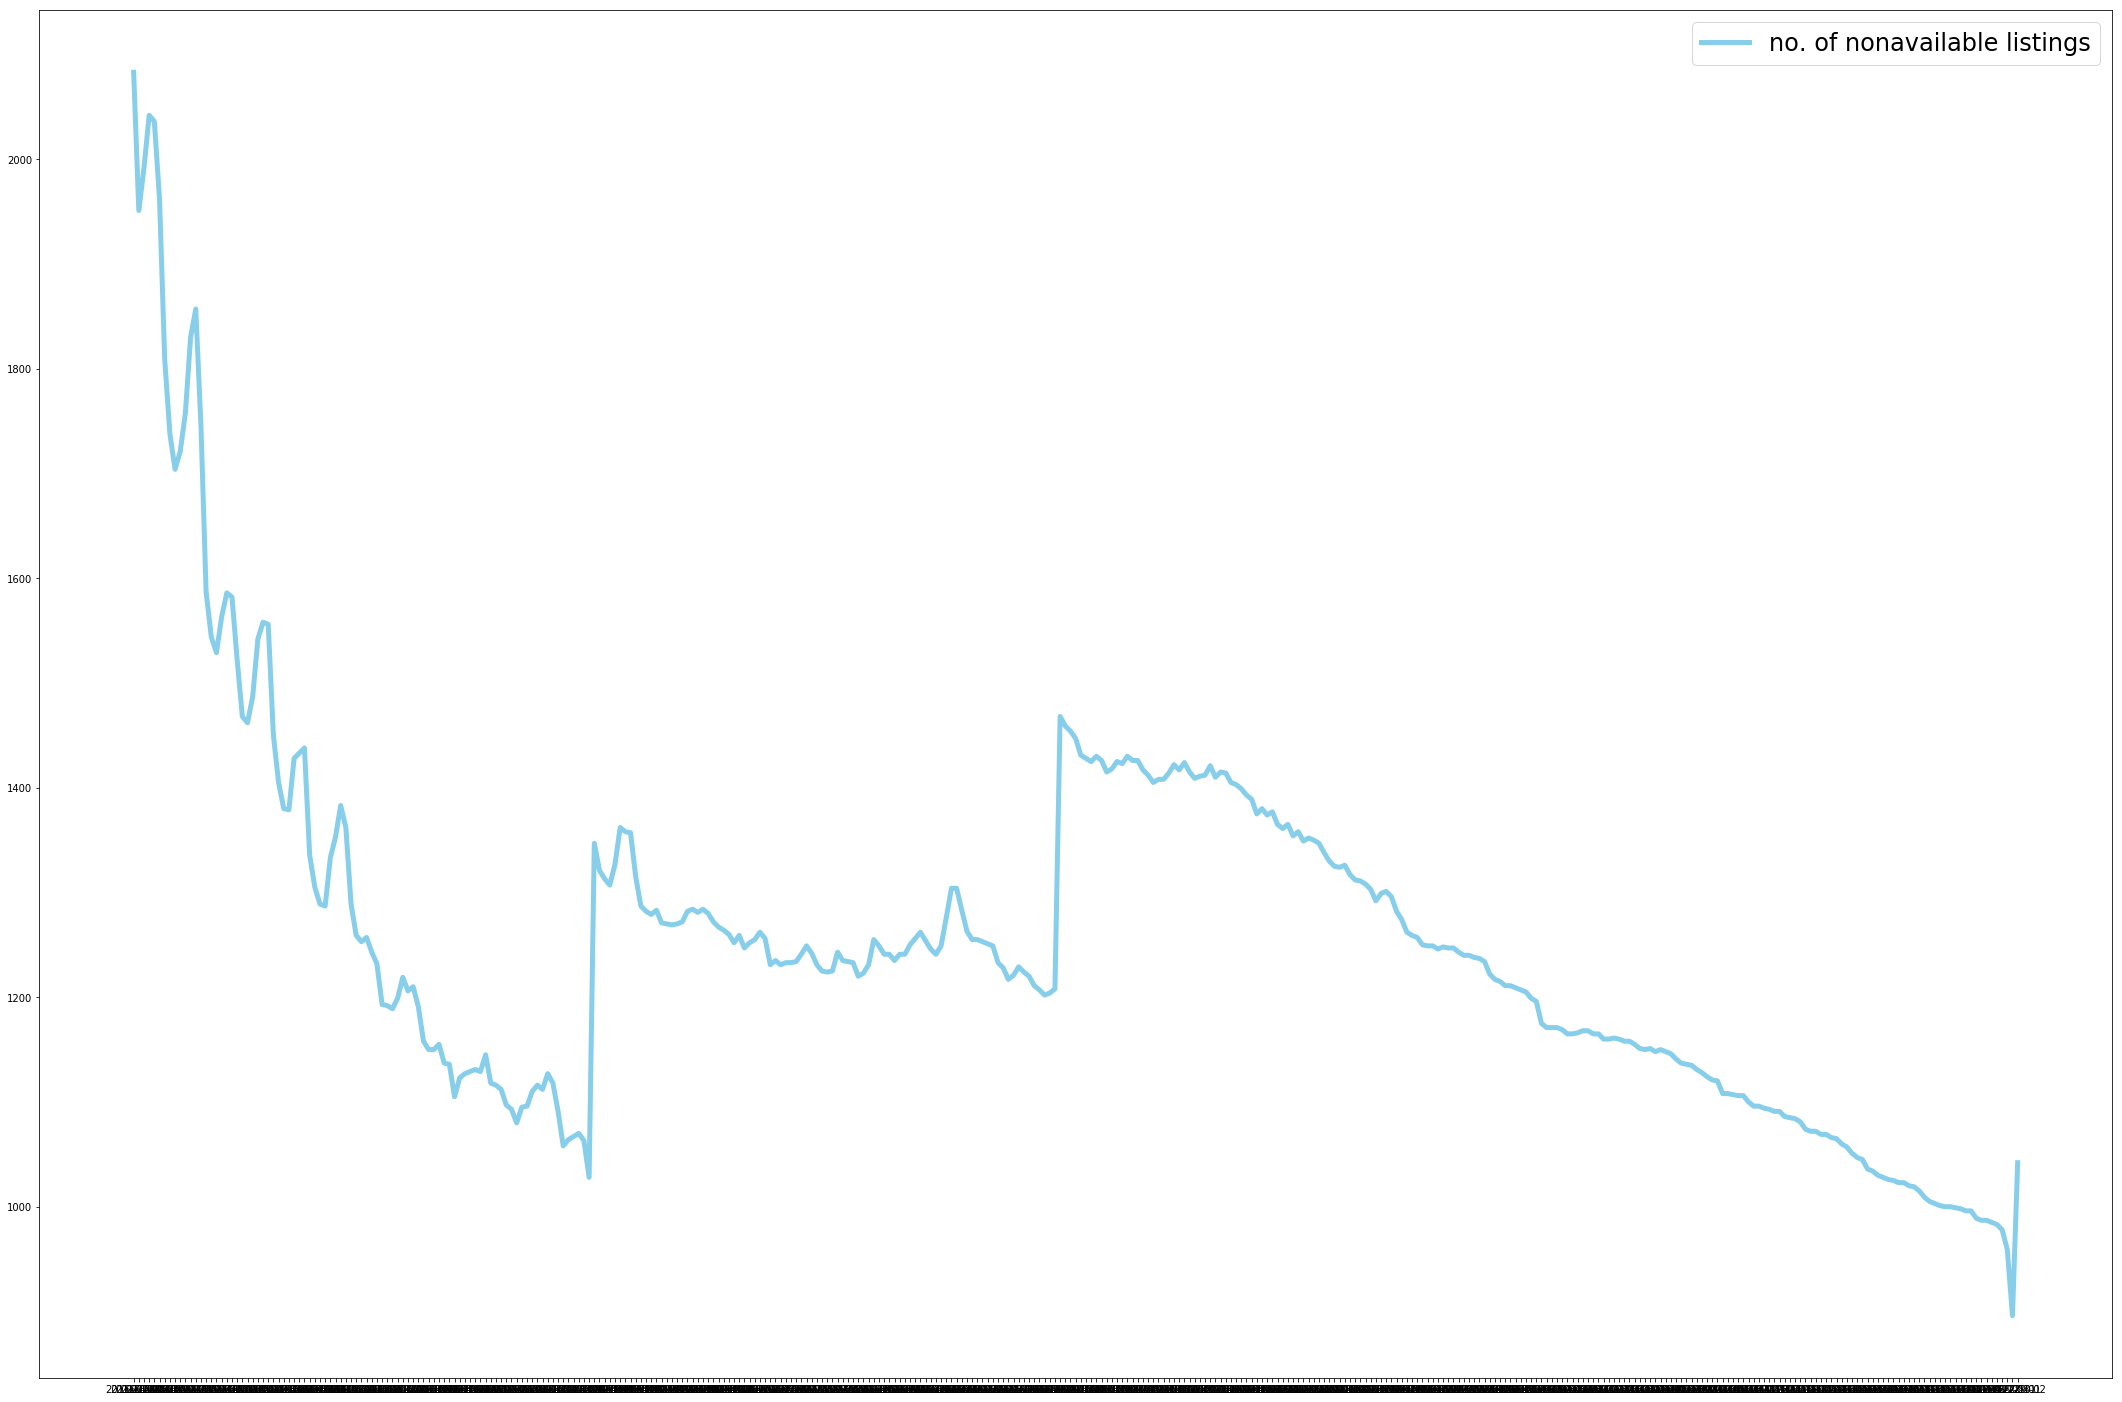

In [482]:
# Data
df=pd.DataFrame({'date': when_popular.index, 'no. of nonavailable listings': when_popular.values })

# plot trend of unavailable listings
plt.figure(figsize=(30,20))
locs, labels = plt.xticks()
plt.rcParams.update({'font.size': 24})
plt.plot( 'date', 'no. of nonavailable listings', data=df, marker='', markerfacecolor='blue', color='skyblue', linewidth=5)
plt.legend()
plt.tight_layout()

We can see from the graph above that there are clear spikes in certain months. To get the exact months, we can find the maximum of non-available listings for the month.

In [483]:
#find date of maximum number of non available listings
when_popular.idxmax()

'2016-01-04'

We can see that the highest number of non available listings were on 2016-01-04. We can get a ranking of the most to least popular dates by sorting this dataset.

In [484]:
when_popular.sort_values(ascending=False).head(10)

date
2016-01-04    2083
2016-01-07    2042
2016-01-08    2036
2016-01-06    1992
2016-01-09    1962
2016-01-05    1951
2016-01-16    1857
2016-01-15    1830
2016-01-10    1809
2016-01-14    1758
Name: listing_id, dtype: int64

The top 10 ranked days are all in January 2016. The chart above shows that the number of unavailable listings has been decreasing into the first two days of 2017, but it remains to be seen if the trend did holds in 2017.

#### 2.2 Where are the most popular areas in a year for rentals of homes in Seattle?

Meanwhile, to get location data, we have to merge the calendar dataset with the listings dataset. In particular, we need to merge it with the location column, which to our interest will be 'neighbourhood_cleansed'. 

To answer this question, we can just utilise the listings dataset and check the neighbourhood where the sum number of times a home is unavailable in a year is maximized. 

In [485]:
#get a copy of the dataset
calendar_time=calendar_clean.copy()

#rename id column to merge on
calendar_time.rename(columns={'listing_id': 'id'},inplace=True)

#get subset of listings data
listings_location=listings[['id','neighbourhood_cleansed']]

#merge datasets
result = pd.merge(calendar_time, listings_location, how='left', on=['id'])

In [486]:
#filter for when not available
result=result[result['available']=='f']

#get year column from date
result['year']= result.date.str[:4]

In [487]:
result.groupby('year')['date'].nunique()

year
2016    363
2017      2
Name: date, dtype: int64

We can see based on the above that we only have two day's worth of data for year 2017, so we can ignore 2017.

In [488]:
#group dataset by date, get sum number of times a listing is unavailable in a year 
result.groupby(['year','neighbourhood_cleansed'])['id'].count().sort_values(ascending=False).head(10)

year  neighbourhood_cleansed   
2016  Broadway                     42773
      Belltown                     26207
      Wallingford                  14744
      Fremont                      14313
      Minor                        13586
      First Hill                   13102
      East Queen Anne              10593
      Lower Queen Anne             10518
      Stevens                      10458
      Central Business District     8683
Name: id, dtype: int64

Meanwhile in the year 2016, Broadway neighbourhood had the highest number of listings that were unavailable.

### Business Question 3: When and where are the highest revenue-generating times of the year for Seattle home-owners? <a id='revenue'></a>

#### 3.1 When are the highest revenue-generating times of the year for Seattle home-owners?

To answer this question, we can use the price column in the listings dataset, as the price column in the calendar dataset is mostly null.

In [489]:
#get copy of dataset
calendar_rev=calendar_clean.copy()

#rename id column to merge on
calendar_rev.rename(columns={'listing_id': 'id'},inplace=True)

#convert listings price data into string, get subset of listings data
listings['price']=listings['price'].replace('[\$,]', '', regex=True).astype(float)
listings_price=listings[['id','price']]

#merge datasets
result_price = pd.merge(calendar_rev, listings_price, how='left', on=['id'])

In order to identify the highest revenue-generating times of the year for Seattle home-owners, we need to analyse the prices of listings that are not available. We assume that if a property is rented at the price of that date (hence is unavailable), it means that that price is the market price, as it is the price that is willingly paid for by a guest.

Conversely, if a listing is available during that period, this would imply that the price is not willingly accepted by the market. 

This assumption follows the real estate definition of a home's market price, as the price agreed upon by a willing renter and a willing homeowner (from [here](https://budgeting.thenest.com/market-value-vs-market-price-4397.html)). 

This is dependent on a number of strong assumptions, namely that there is perfect competition amongst listings in a day and they are all homogenous - price and date are the only determining factors for this market. All other factors that may lead to a home being priced higher might be encapsulated in the market value of the home, which is not necessarily the price the renter pays. In the interest of keeping this analysis simple, this are the simplifying assumptions we are making.

Moreover, given the motivation of the analysis, these simplifications are acceptable. As a Seattle homeowner, I may be interested in when are the days of the year that guests/renters are willing to pay higher for my home, so that I can list a competitive price during tha ttime. There is less of a priority to know all the other factors that may lead to a price being higher in that particular time.

We take an average price of all non available listings in each date to get the trend of average price for listings across time.

In [490]:
result_price_xavailable=result_price[result_price['available']=='f']

result_price_xavailable=result_price_xavailable.groupby('date')['price'].mean()

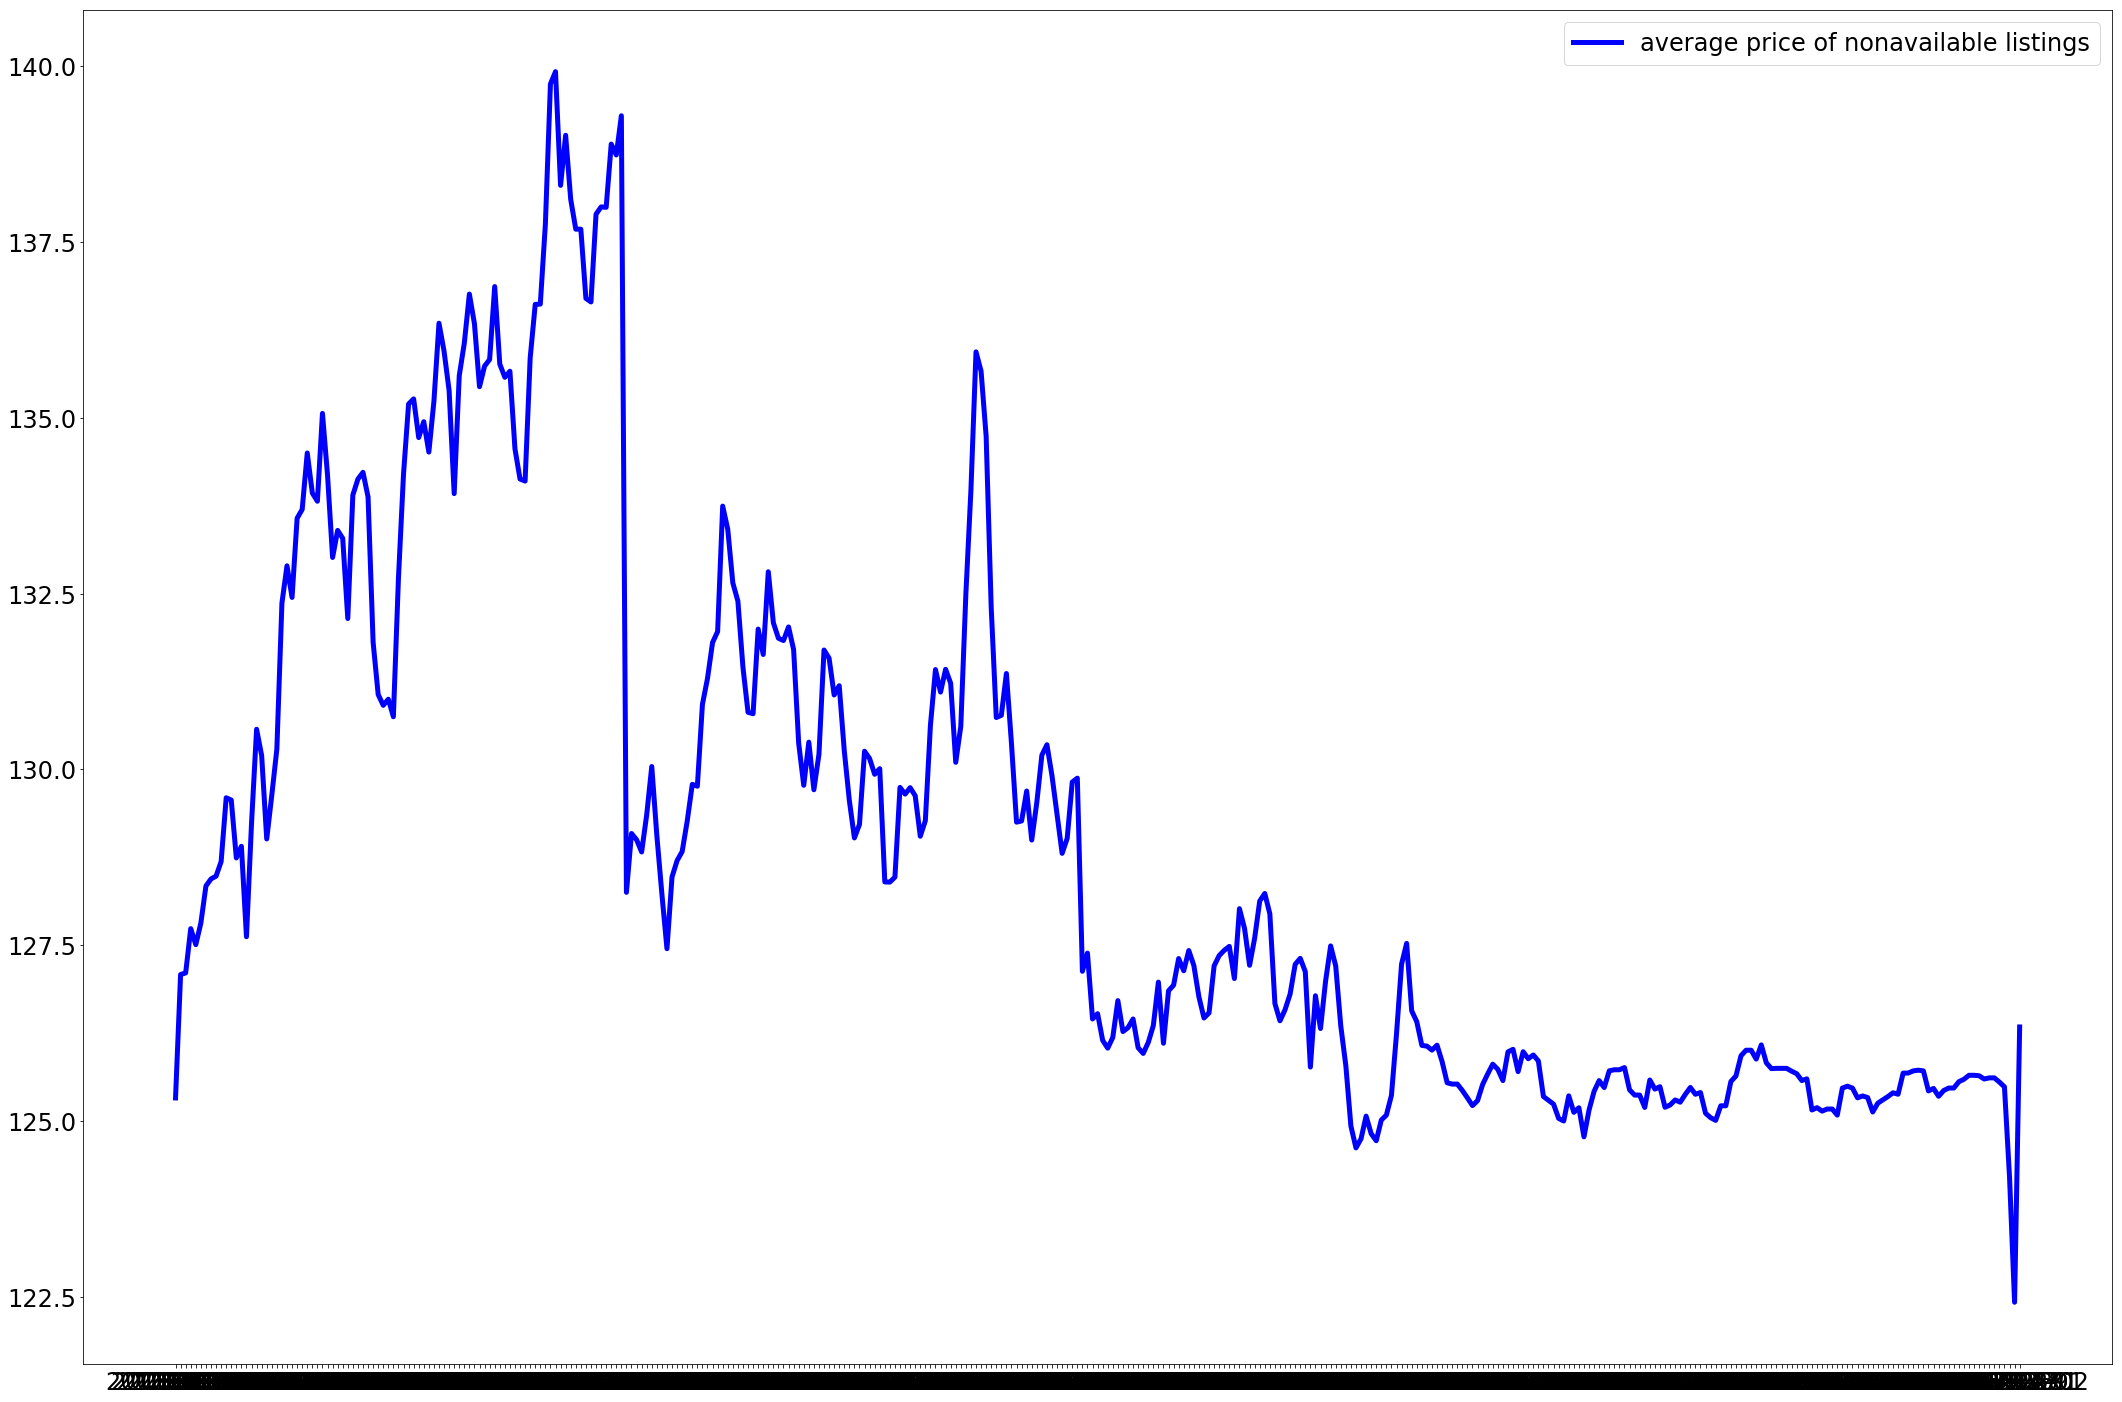

In [491]:
# Data
df=pd.DataFrame({'date': result_price_xavailable.index, 'average price of nonavailable listings': result_price_xavailable.values })

#plot trend of prices
plt.figure(figsize=(30,20))
plt.rcParams.update({'font.size': 24})
plt.plot('date', 'average price of nonavailable listings', data=df, marker='', markerfacecolor='blue', color='blue', linewidth=5)
plt.legend()
plt.tight_layout()

In [492]:
#find date of maximum mean price of non available listings
result_price_xavailable.idxmax()

'2016-03-19'

In [493]:
result_price_xavailable.sort_values(ascending=False).head(10)

date
2016-03-19    139.920428
2016-03-18    139.744578
2016-04-01    139.294043
2016-03-21    139.016336
2016-03-30    138.890777
2016-03-31    138.735618
2016-03-20    138.303318
2016-03-22    138.104960
2016-03-28    137.997549
2016-03-29    137.991463
Name: price, dtype: float64

From the graph and the data above, we can see that the highest prices appear to be in the month of March in 2016. We can see a clear trend that average prices of non available listings start to drop towards 2017, and we only have two day's worth of data in 2017, so it remains to be seen if the trend holds in 2017.

#### 3.2 Where are the highest revenue-generating areas for Seattle homeowners?

To answer this question, we can just utilise the listings dataset and take an average price of a home in each neighbourhood. This simplifies the analysis as it assumes the prices don't fluctuate in each area across time, which of course we showed in 3.1 that this is not the case. 

However, this simplification may be valid as from the perspective of a homeowner who may be scouting or already owns properties on AirBnB, I would not be buying properties so often, and having time as an additional dimension would not affect my decision much. I would not be interested in such short term property value fluctuations.

In [494]:
#get subset of listings data
listings_location=listings[['id','neighbourhood_cleansed','price']]

In [495]:
#sort neighbourhood by average price of house
listings_location.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False).head(10)

neighbourhood_cleansed
Southeast Magnolia     242.571429
Portage Bay            227.857143
Westlake               212.800000
West Queen Anne        190.654545
Industrial District    187.500000
Briarcliff             183.583333
Montlake               182.375000
Pioneer Square         174.000000
Fauntleroy             173.444444
Sunset Hill            170.933333
Name: price, dtype: float64

From the above, we can see that Southeast Magnolia had the highest average price of listings.

Comparing this analysis with 2.2, we can see that the most popular neighbourhood in a year may not give the most revenue to a homeowner (which implies that price could be a factor that leads to how popular a neighbourhood is). To investigate this, we can combine the analysis from 3.2 and 2.2 to see what would be most revenue generating to a homeowner, i.e. get them the most guests in a year while making the most revenue.

To combine the analysis, we have to look at the prices of the most popular homes and calculate the revenue based on the number of listings unavailable in a day with the price, for the year.

In [496]:
#merge dataset with relevant columns together
listings_price=listings[['id','price','neighbourhood_cleansed']]

#merge datasets
result_price_2 = pd.merge(calendar_rev, listings_price, how='left', on=['id'])

#calculate revenue based on availability - if unavailable, count revenues
result_price_2['revenue']=np.where(result_price_2['available']=='f', result_price_2['price']*1, 0)

#get year column from date
result_price_2['year']= result_price_2.date.str[:4]

In [497]:
result_price_2.groupby(['year','neighbourhood_cleansed'])['revenue'].sum().sort_values(ascending=False).head(10)

year  neighbourhood_cleansed   
2016  Broadway                     5076428.0
      Belltown                     4299989.0
      Wallingford                  2161405.0
      Fremont                      1959851.0
      Minor                        1835319.0
      First Hill                   1722824.0
      East Queen Anne              1610595.0
      Stevens                      1591196.0
      Central Business District    1416299.0
      Lower Queen Anne             1365348.0
Name: revenue, dtype: float64

The top 10 neighbourhoods with homes that were most popular in the year, hence generating the highest revenue, are as the above. Broadway is the clear top revenue generating neighbourhood for Seattle home-owners, while Belltown is a distant second. Meanwhile, the others are about 60% less revenue generating compared to Broadway.

Hence, as a clear actionable goal, a Seattle homeowner in this area should consider renting out their home at the competitive price, as it offers the highest revenues in 2016.